In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read data
# DATA_FILE = "data_test.txt" # test data
DATA_FILE = "data.txt" # final data
data = []
with open(DATA_FILE) as data_file:
    for line in data_file:
        nums = [float(num) for num in line.split()]
        data.append(nums)
X = np.array(data)
print(X.shape)

(1000, 100)


In [3]:
# Data standardization
sigma = X.std(axis=0)
# print("sigma", sigma)
mu = X.mean(axis=0)
# print("mu", mu)
X_std = (X - mu)/sigma
# print("X_std\n", X_std)

In [4]:
# compare with sklearn library standardization for debug
from sklearn.preprocessing import StandardScaler
X_std_sk = StandardScaler().fit_transform(X)
# print("X_std_sk\n",X_std_sk)

In [5]:
# Construct the co-variance matrix
# X = X_std # use standardized data
N = X.shape[0] - 1# number of instances
mu = X.mean(axis=0)
X_minus_mu = X - mu
cov_mat = X_minus_mu.T.dot(X_minus_mu) / N
print("cov_mat\n", cov_mat.shape)

# compare with numpy library coverient matrix for debug
# cov_mat_np = np.cov(X.T)
# print("cov_mat_np\n",cov_mat_np)

cov_mat
 (100, 100)


In [6]:
# eigen vectors and eigen values of the co-variance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# print('Eigenvectors\n',eig_vecs)
# print('Eigenvalues\n', eig_vals)

In [7]:
# choose two best eigen vector
eigen_val_vec_pairs = []
for i in range(len(eig_vals)):
    eigen_val = np.abs(eig_vals[i])
    eigen_vec = eig_vecs[:,i]
    eigen_val_vec_pairs.append(
        (eigen_val,eigen_vec)
    )
# sort by absalute value of the eigen value
eigen_val_vec_pairs.sort(key=lambda eigen_val_vec_pair : eigen_val_vec_pair[0],reverse=True)
# eigen_val_vec_pairs

In [8]:
principal_components = np.array([eigen_val_vec_pairs[0][1],eigen_val_vec_pairs[1][1]]).T
# print("principal_components shape",principal_components)

X_projected = np.dot(X,principal_components)
# print('X_projected.shape\n', X_projected.shape)

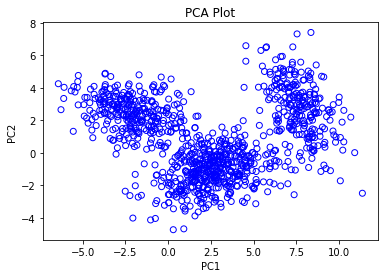

In [9]:
# plot projected data
plt.title('PCA Plot') 
plt.xlabel('PC1') 
plt.ylabel('PC2') 
plt.scatter(X_projected[:,0],X_projected[:,1],facecolors='none',edgecolors='b')
plt.show()

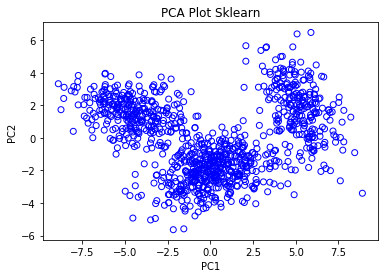

In [10]:
# compare my pca plot with sklearn plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

plt.title('PCA Plot Sklearn') 
plt.xlabel('PC1') 
plt.ylabel('PC2') 
plt.scatter(principalComponents[:,0],principalComponents[:,1],facecolors='none',edgecolors='b')
plt.show()

In [11]:
# probability of generation of x from Gaussian distribution with mean_vect, cov_mat
# P(x | mean_vec,cov_mat)
def gaussian_prob(x,mean_vec,cov_mat):
    D = len(x)
    det_cov = np.linalg.det(cov_mat)
    x_minus_mu = x - mean_vec
    inv_cov = np.linalg.inv(cov_mat)
    z_score = (-1/2) * np.dot(np.dot(x_minus_mu,inv_cov), # 1xD . DxD = 1xD
                              x_minus_mu.T)               # 1xD . Dx1 = 1x1
    return np.exp(z_score) * ((2 * np.pi)**D * det_cov )**(-1/2)


# test gaussian_prob
mu = np.array([1,2])
sigma = np.array([[10,3],[3,2]])
x = np.array([1.5,1.5])
print("p_mine",gaussian_prob(x,mu,sigma))
# check with library for debug
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=mu, cov=sigma)
print("p_scipy",var.pdf(x))

p_mine 0.03911027114512301
p_scipy 0.03911027114512302


In [12]:
def log_likelihood(X,means,covs,w):
    """Calculate
    ln p(X|μ,Σ,w) = \sum_{i=1}^{N} ln p(x_i|μ,Σ,w)
                  = \sum_{i=1}^{N} ln \sum_{k=1}^{K} w_k N(x_i|μ_k,Σ_k) 
    """
    sum_ln = 0
    for x in X:
        sum_wN = 0
        for k in range(len(means)):
            sum_wN += ( w[k] * gaussian_prob(x,means[k],covs[k]) )
        sum_ln += np.log(sum_wN)
    return sum_ln 

In [13]:
# EM Algorithm
def em_algorithm(X,n_cluster,max_iter=1000,eps=1e-4):
    n_data = len(X)
    # initial mean = choose k random data point as mean
    indices = np.random.choice(range(n_data),n_cluster,replace=False)
    means = X[indices]
    
    # initial covs = cov of the data
    cov_X = np.cov(X.T)
    covs = np.array([cov_X for _ in range(n_cluster)])

    # initial weight = 1/k
    w = np.array([1/n_cluster for _ in range(n_cluster)])

    # initial log likelihood
    likelihood = log_likelihood(X,means,covs,w)
    for _ in range(max_iter):
        # -------------E Step-------------
        p = np.zeros((n_data,n_cluster))
        for i in range(n_data):
            for k in range(n_cluster):
                p[i,k] = w[k] * gaussian_prob(X[i],means[k],covs[k])
            # normalize
            p[i] /= np.sum(p[i])

        # -------------M Step-------------
        for k in range(n_cluster):
            # adjust mean
            new_mean = np.zeros_like(means[k])
            sum_p_ik = 0
            for i in range(n_data):
                new_mean += p[i,k] * X[i]
                sum_p_ik += p[i,k]
            means[k] = new_mean/sum_p_ik

            # adjust cov
            new_cov = np.zeros_like(covs[k])
            for i in range(n_data):
                x_minus_mu = X[i] - means[k]
                new_cov += p[i,k] * np.outer(x_minus_mu,x_minus_mu)
                # np.dot(x.T,x) -> dot product, not (dx1)*(1xd) = (dxd) matrix
                # np.outer(x,x) -> gives      ,     (dx1)*(1xd) = (dxd) matrix
            covs[k] = new_cov/sum_p_ik

            # adjust w
            new_w = np.zeros_like(w[k])
            for i in range(n_data):
                new_w += p[i,k]
            w[k] = new_w/n_data

        # -------------Evaluation-------------
        likelihood_new = log_likelihood(X,means,covs,w)
        if (likelihood_new - likelihood) < eps: break
        likelihood = likelihood_new
    return {"mean":means,"cov":covs,"w" : w}

In [14]:
mean_cov = em_algorithm(X_projected,3)
means = mean_cov["mean"]
covs = mean_cov["cov"]

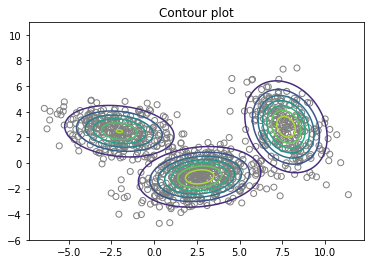

In [15]:
# this is not my code: copied from internet to plot contour

def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

def plot_contours(data, means, covs, title):
    plt.figure()
    plt.scatter(data[:,0],data[:,1],facecolors='none',edgecolors='#808080')
    delta = 0.025
    k = len(means)
    x = np.arange(-6.0, 11.0, delta)
    y = np.arange(-6.0, 11.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z)
    plt.title(title)


plot_contours(X_projected, means, covs,"Contour plot")